## Install kaggle 

In [ ]:
!gdown --id '11FrbjVv6rOQnzvF1VCIwLbVkUfHXND4m'
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=11FrbjVv6rOQnzvF1VCIwLbVkUfHXND4m
To: /content/kaggle.json
100% 67.0/67.0 [00:00<00:00, 57.6kB/s]


## Download dataset files

In [ ]:
# Download dataset files
!kaggle datasets download rikdifos/credit-card-approval-prediction
! unzip credit-card-approval-prediction.zip

  0% 0.00/5.32M [00:00<?, ?B/s]
100% 5.32M/5.32M [00:00<00:00, 49.0MB/s]
Archive:  credit-card-approval-prediction.zip
  inflating: application_record.csv  
  inflating: credit_record.csv       


## Import important libraries 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import tensorflow as tf 
%matplotlib inline 


##Reading both datasets

In [ ]:
credit_df=pd.read_csv('credit_record.csv')
aplication_df=pd.read_csv('application_record.csv')

##Invistigate credit_records The dataset

Let's see the historical transactions for each customer

In [ ]:
grouped=credit_df.groupby('ID')['STATUS'].value_counts()
grouped

ID       STATUS
5001711  0          3
         X          1
5001712  0         10
         C          9
5001713  X         22
                   ..
5150483  X         18
5150484  0         12
         C          1
5150485  0          2
5150487  C         30
Name: STATUS, Length: 94143, dtype: int64

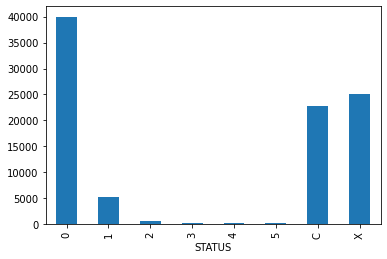

In [ ]:
credit_df.groupby('STATUS').count()
number_of_customer_for_each_status=grouped.groupby('STATUS').count()
number_of_customer_for_each_status.plot(kind='bar')


Most customers pay off their loans in 1-29 days<br>
High percetage of customers don't borrow loans <br>
Also High percetage of customers pay off their loan forever <br>
Few people are late in paying off their loans 

In [ ]:
credit_grouped=pd.get_dummies(data=credit_df,columns=['STATUS'],
                              prefix='',prefix_sep='').groupby('ID')[sorted(credit_df['STATUS'].unique().tolist())].sum()
credit_grouped=credit_grouped.rename(columns=
                      {'0':'pastdue_1_29',
                       '1':'pastdue_30_59',
                       '2':'pastdue_60_89',
                       '3':'pastdue_90_119',
                       '4':'pastdue_120_149',
                       '5':'pastdue_over_150',
                       'C':'paid_off',
                       'X':'no_loan',
                      })

overall_pastdue=['pastdue_1_29','pastdue_30_59',	'pastdue_60_89',	'pastdue_90_119'	,'pastdue_120_149',	'pastdue_over_150']
credit_grouped['window']=credit_df.groupby('ID')['MONTHS_BALANCE'].max()-credit_df.groupby('ID')['MONTHS_BALANCE'].min()
credit_grouped['over_90']=credit_grouped[['pastdue_90_119'	,'pastdue_120_149'	,'pastdue_over_150']].sum(axis=1)
credit_grouped['less_90']=credit_grouped[['pastdue_1_29','pastdue_30_59',	'pastdue_60_89']].sum(axis=1)
credit_grouped['overall_pastdue']=credit_grouped[overall_pastdue].sum(axis=1)
credit_grouped['paid_pastdue_diff']=credit_grouped['paid_off']- credit_grouped['overall_pastdue']

credit_grouped.head()

,pastdue_1_29,pastdue_30_59,pastdue_60_89,pastdue_90_119,pastdue_120_149,pastdue_over_150,paid_off,no_loan,window,over_90,less_90,overall_pastdue,paid_pastdue_diff
ID,,,,,,,,,,,,,
5001711,3,0,0,0,0,0,0,1,3,0,3,3,-3
5001712,10,0,0,0,0,0,9,0,18,0,10,10,-1
5001713,0,0,0,0,0,0,0,22,21,0,0,0,0
5001714,0,0,0,0,0,0,0,15,14,0,0,0,0
5001715,0,0,0,0,0,0,0,60,59,0,0,0,0


<h1>Determine Good and Bad Customers</h1>
We choose to discard all records that last for less than 20 months to reduce noises (too short obeservation window won't be able to show the behaviour of the customers)
<br>
Good customer conditions :<br>
Check the difference between numbers of times the customer paid off and the number of late and if it is more than threshold then pure good customer or he hasn't take any loans else we should take another check <br>

paid_pastdue_diff >=3 or no_loan==window
<br><br>
Also check if he too late or pay off in small period and has a suitable differance paid_pastdue_diff  <br>
paid_pastdue_diff >=-2 and paid_pastdue_diff < 3 and less_90 >= over_90 good <br>

If the customer doesn't achive these conditions then he is a bad customr







In [ ]:
credit_grouped=credit_grouped[credit_grouped['window']>20]
target=[]
for index,row in credit_grouped.iterrows() :
  if row['paid_pastdue_diff'] >=3 or (row ['no_loan']==row['window']) :
    target.append(1)
  elif row['paid_pastdue_diff'] >-2 and row['paid_pastdue_diff'] <3 and (row['less_90'] >=row['over_90']) :
    target.append(1)
  else:
    target.append(0)

credit_grouped['good_or_bad']=target
credit_grouped['good_or_bad'].value_counts()

1    14775
0     6149
Name: good_or_bad, dtype: int64

A good point that we reached to a balanced split

##Invistigate aplication_records dataset 

In [ ]:
aplication_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Check duplication

In [ ]:
aplication_df.duplicated().sum()

0

<h1>Let's Merge the to datasets to have a full insights <br></h1>
Credit_record dataset don't has only the target ,but aslo has a very interesting historical transactions features that will add benifits

In [ ]:
# features=['no_loan',	'window',	'over_90',	'less_90',	'overall_pastdue'	,'paid_pastdue_diff','good_or_bad']
features=['window','over_90','overall_pastdue','good_or_bad']

most_important_features=credit_grouped.loc[:,features]
customers_df=pd.merge(aplication_df,most_important_features,on='ID')
customers_df.index=customers_df['ID']
customers_df=customers_df.drop('ID',axis=1)
customers_df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,good_or_bad
ID,,,,,,,,,,,,,,,,,,,,,
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0,7,1
5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0,6,1
5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,38,0,6,1
5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,42,0,35,0
5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0,25,0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149145,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,2.0,25,0,10,1
5149158,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,2.0,28,0,12,1
5149729,M,Y,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-19101,-1721,1,0,0,0,NaN,2.0,21,0,17,0


##Data Visualization

Visualize continuous values distribution 

<Figure size 1080x1080 with 0 Axes>

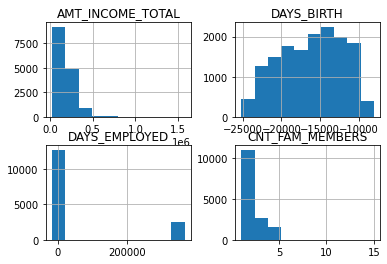

In [ ]:
continuous=['AMT_INCOME_TOTAL', 'DAYS_BIRTH',	'DAYS_EMPLOYED' ,'CNT_FAM_MEMBERS']
plt.figure(figsize=(15,15))
customers_df[continuous].hist()
plt.show()

We can notice left skewed data in AMT_INCOME_TOTAL and CNT_FAM_MEMBERS ,so we will convert it to its log value

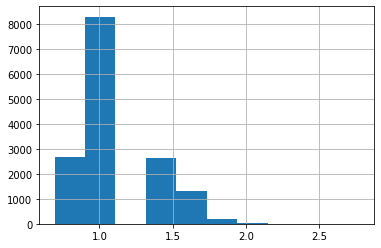

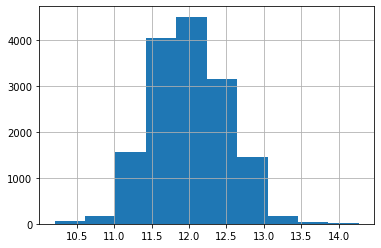

In [ ]:
customers_df['CNT_FAM_MEMBERS']=np.log1p(customers_df['CNT_FAM_MEMBERS'])
customers_df['CNT_FAM_MEMBERS'].hist()
plt.show()
customers_df['AMT_INCOME_TOTAL']=np.log1p(customers_df['AMT_INCOME_TOTAL'])
customers_df['AMT_INCOME_TOTAL'].hist()

<h1>Determine outlier

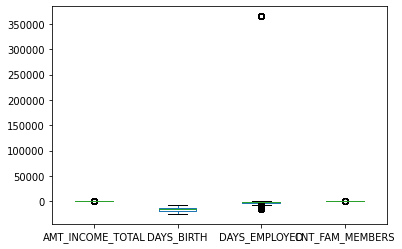

In [ ]:
customers_df[continuous].plot(kind='box')

<h1>Remove outlier

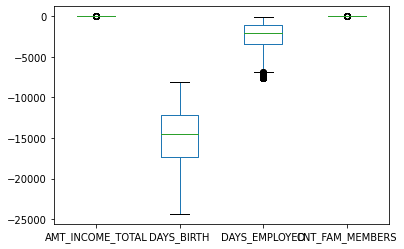

In [ ]:
outliers_columns=['AMT_INCOME_TOTAL','DAYS_EMPLOYED']
for col in outliers_columns :
    Q1 = customers_df[col].quantile(0.25)
    Q3 = customers_df[col].quantile(0.75)
    IQR = Q3-Q1
    customers_df=customers_df[(Q1-1.5*IQR <= customers_df[col]) & (customers_df[col] <= Q3+1.5*IQR)]
customers_df[continuous].plot(kind='box')

<h1>Split the target and features 

In [ ]:
x=customers_df.loc[:,:'overall_pastdue']
y=customers_df['good_or_bad']
x

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue
ID,,,,,,,,,,,,,,,,,,,,
5008806,M,Y,Y,0,11.630717,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,1.098612,29,0,7
5008810,F,N,Y,0,12.506181,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,0.693147,26,0,6
5008811,F,N,Y,0,12.506181,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,0.693147,38,0,6
5112956,M,Y,Y,0,12.506181,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,1.098612,42,0,35
5008825,F,Y,N,0,11.779136,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,1.098612,25,0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149145,M,Y,Y,0,12.419170,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,1.098612,25,0,10
5149158,M,Y,Y,0,12.419170,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,1.098612,28,0,12
5149729,M,Y,Y,0,11.407576,Working,Secondary / secondary special,Married,House / apartment,-19101,-1721,1,0,0,0,NaN,1.098612,21,0,17


<h1>Train test spilt</h1>

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

<h3>Invistigates features with the output to determine its effect 

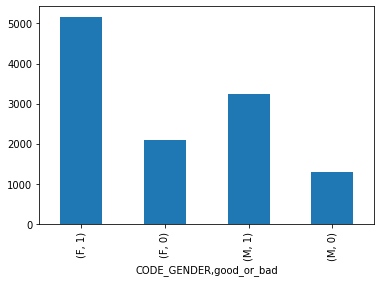

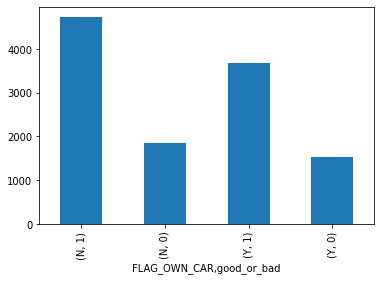

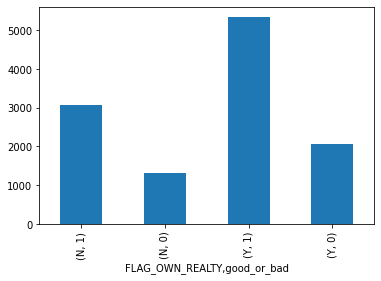

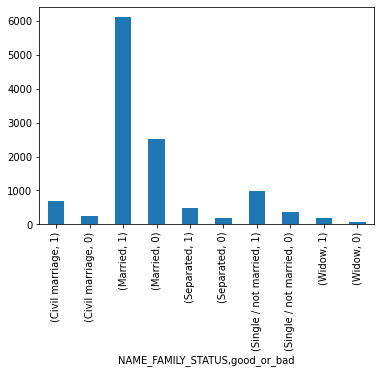

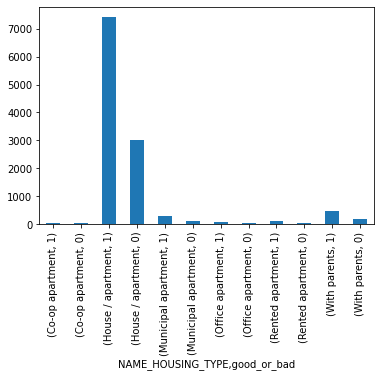

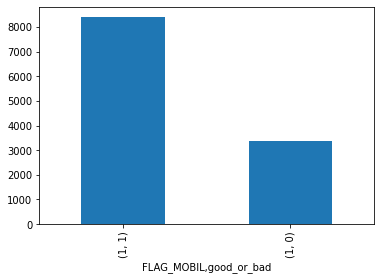

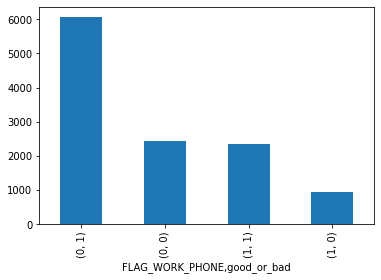

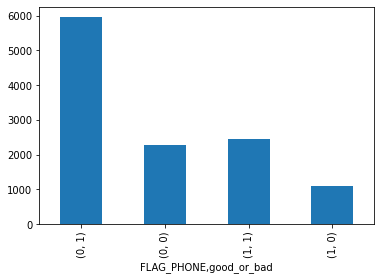

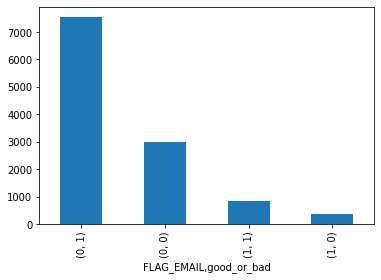

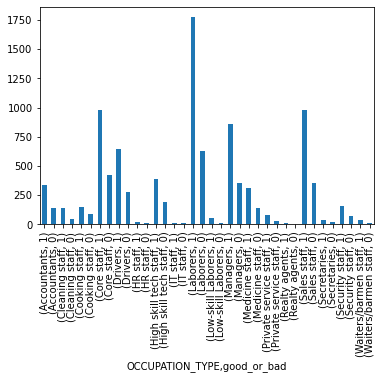

In [ ]:
cols=['CODE_GENDER',	'FLAG_OWN_CAR',
            'FLAG_OWN_REALTY','NAME_FAMILY_STATUS',	'NAME_HOUSING_TYPE',
            'FLAG_MOBIL'	,'FLAG_WORK_PHONE',	'FLAG_PHONE',	'FLAG_EMAIL'	,'OCCUPATION_TYPE']
for col in  cols:
  customers_df.groupby(col)['good_or_bad'].value_counts().plot(kind='bar')
  plt.show()
  print()

Form the insights above I will drop these features :<br>
1-FLAG_MOBILE because it has one value <br>
2-FLAG_WORK_PHONE ,because it has small effect to determine bad or good <br>
3-FLAG_PHONE ,because it has small effect to determine bad or good<br>
4-FLAG_EMAIL ,because it has small effect to determine bad or good<br>


In [ ]:
x_train=x_train.drop(['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'],axis=1)

## Data preprocessing

In [ ]:
# Convert days birth to age column and days employed to work years 
x_train['AGE']=(x_train['DAYS_BIRTH']/365)*-1
x_train['AGE']=x_train['AGE'].apply(lambda v : int(v))
x_train['WORK_YEARS']=x_train['DAYS_EMPLOYED']/365
x_train['WORK_YEARS']=x_train['WORK_YEARS'].apply(lambda v : int(v*-1) if v <0 else 0)
x_train=x_train.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'])
x_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,AGE,WORK_YEARS
ID,,,,,,,,,,,,,,,,
5008984,M,Y,Y,0,11.630717,State servant,Secondary / secondary special,Married,House / apartment,Drivers,1.098612,58,0,0,57,6
5149803,F,N,Y,0,11.813037,State servant,Incomplete higher,Single / not married,With parents,NaN,0.693147,45,0,13,27,5
5105187,M,N,Y,0,12.660331,Commercial associate,Higher education,Single / not married,House / apartment,Laborers,0.693147,25,0,22,28,1
5062185,F,Y,Y,2,11.877576,Working,Higher education,Married,House / apartment,Accountants,1.609438,25,0,9,39,1
5096728,M,Y,N,0,11.813037,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,1.098612,22,0,0,29,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062471,M,N,Y,1,11.630717,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,1.386294,49,0,36,50,3
5046348,M,N,Y,1,12.100718,Working,Lower secondary,Married,House / apartment,NaN,1.386294,38,0,7,28,4
5126128,F,Y,N,0,11.184435,Working,Secondary / secondary special,Married,House / apartment,Medicine staff,1.098612,39,0,39,41,0


In [ ]:
# children count is subset of family size so we can drop the children count feature 
x_train=x_train.drop(columns=['CNT_CHILDREN'])

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 5008984 to 5041127
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          9424 non-null   object 
 1   FLAG_OWN_CAR         9424 non-null   object 
 2   FLAG_OWN_REALTY      9424 non-null   object 
 3   AMT_INCOME_TOTAL     9424 non-null   float64
 4   NAME_INCOME_TYPE     9424 non-null   object 
 5   NAME_EDUCATION_TYPE  9424 non-null   object 
 6   NAME_FAMILY_STATUS   9424 non-null   object 
 7   NAME_HOUSING_TYPE    9424 non-null   object 
 8   OCCUPATION_TYPE      7825 non-null   object 
 9   CNT_FAM_MEMBERS      9424 non-null   float64
 10  window               9424 non-null   int64  
 11  over_90              9424 non-null   int64  
 12  overall_pastdue      9424 non-null   int64  
 13  AGE                  9424 non-null   int64  
 14  WORK_YEARS           9424 non-null   int64  
dtypes: float64(2), int64(5), obje

<h1> Dealing with the missing values </h1>
OCCUPATION_TYPE feature has a missing values in it and its a categorical feature so we will fill these values with most frequent value for this column and will use the simple imputer to do this

In [ ]:
from sklearn.impute import SimpleImputer 
imputer =SimpleImputer(strategy='most_frequent')
x_imputed=pd.DataFrame(imputer.fit_transform(x_train),index=x_train.index,columns=x_train.columns)
# Imputer change the type of the features so we should reset it again
x_imputed=x_imputed.astype(x_train.dtypes)
#Convert binary types to categorical types to be ready for one hot encoding 
# x_imputed['FLAG_MOBIL']=x_imputed['FLAG_MOBIL'].astype('object')
# x_imputed['FLAG_WORK_PHONE']=x_imputed['FLAG_WORK_PHONE'].astype('object')
# x_imputed['FLAG_PHONE']=x_imputed['FLAG_PHONE'].astype('object')
# x_imputed['FLAG_EMAIL']=x_imputed['FLAG_EMAIL'].astype('object')
# Change no_load type to int64 
# x_imputed['no_loan']=x_imputed['no_loan'].astype('int64')
x_imputed['CNT_FAM_MEMBERS']=x_imputed['CNT_FAM_MEMBERS'].astype('int64')
x_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 5008984 to 5041127
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          9424 non-null   object 
 1   FLAG_OWN_CAR         9424 non-null   object 
 2   FLAG_OWN_REALTY      9424 non-null   object 
 3   AMT_INCOME_TOTAL     9424 non-null   float64
 4   NAME_INCOME_TYPE     9424 non-null   object 
 5   NAME_EDUCATION_TYPE  9424 non-null   object 
 6   NAME_FAMILY_STATUS   9424 non-null   object 
 7   NAME_HOUSING_TYPE    9424 non-null   object 
 8   OCCUPATION_TYPE      9424 non-null   object 
 9   CNT_FAM_MEMBERS      9424 non-null   int64  
 10  window               9424 non-null   int64  
 11  over_90              9424 non-null   int64  
 12  overall_pastdue      9424 non-null   int64  
 13  AGE                  9424 non-null   int64  
 14  WORK_YEARS           9424 non-null   int64  
dtypes: float64(1), int64(6), obje

<h1>Dealing with categorical value<br></h1>
Firstly we invistigate them

In [ ]:
from pandas.core.algorithms import value_counts
categorical_df=x_imputed.select_dtypes('object')
categorical_df.nunique()

CODE_GENDER             2
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
NAME_INCOME_TYPE        5
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      5
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        18
dtype: int64

We can notice that only OCCUPATION_TYPE feature has a high cadinality and the rest is low cadinality .<br>
so we will use target encoding for OCCUPATION_TYPE  and one hot encoding for the rest .

In [ ]:
# install category_encoders
!pip install category_encoders

     |████████████████████████████████| 82 kB 350 kB/s 


In [ ]:
from category_encoders import MEstimateEncoder
target_encoder=MEstimateEncoder(m=5,cols=['OCCUPATION_TYPE'])
# train the encoder with the 0.25 of the data to prevent overfitting 
x_encode=x_imputed.sample(frac=0.25)
y_encode=y_train[x_encode.index]
target_encoder.fit(x_encode,y_encode)
# transform the categorical feature
x_encoded=target_encoder.transform(x_imputed)
x_encoded['OCCUPATION_TYPE'].unique()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


array([0.68891279, 0.73099808, 0.75349835, 0.73049941, 0.71432138,
       0.81534006, 0.65330033, 0.73137144, 0.71821923, 0.67624396,
       0.64834983, 0.66217573, 0.62026033, 0.67688321, 0.78639643,
       0.81013016, 0.57279287])

In [ ]:
x_encoded

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,AGE,WORK_YEARS
ID,,,,,,,,,,,,,,,
5008984,M,Y,Y,11.630717,State servant,Secondary / secondary special,Married,House / apartment,0.688913,1,58,0,0,57,6
5149803,F,N,Y,11.813037,State servant,Incomplete higher,Single / not married,With parents,0.730998,0,45,0,13,27,5
5105187,M,N,Y,12.660331,Commercial associate,Higher education,Single / not married,House / apartment,0.730998,0,25,0,22,28,1
5062185,F,Y,Y,11.877576,Working,Higher education,Married,House / apartment,0.753498,1,25,0,9,39,1
5096728,M,Y,N,11.813037,Commercial associate,Secondary / secondary special,Married,House / apartment,0.730998,1,22,0,0,29,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062471,M,N,Y,11.630717,Commercial associate,Secondary / secondary special,Married,House / apartment,0.688913,1,49,0,36,50,3
5046348,M,N,Y,12.100718,Working,Lower secondary,Married,House / apartment,0.730998,1,38,0,7,28,4
5126128,F,Y,N,11.184435,Working,Secondary / secondary special,Married,House / apartment,0.662176,1,39,0,39,41,0


<h1>Standardization</h1>
I have noticed that features are in different ranges so standardization is a very good way to solve this


In [ ]:
# Get numiric data
numiric_data=x_encoded._get_numeric_data()
numiric_data

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,AGE,WORK_YEARS
ID,,,,,,,,
5008984,11.630717,0.688913,1,58,0,0,57,6
5149803,11.813037,0.730998,0,45,0,13,27,5
5105187,12.660331,0.730998,0,25,0,22,28,1
5062185,11.877576,0.753498,1,25,0,9,39,1
5096728,11.813037,0.730998,1,22,0,0,29,6
...,...,...,...,...,...,...,...,...
5062471,11.630717,0.688913,1,49,0,36,50,3
5046348,12.100718,0.730998,1,38,0,7,28,4
5126128,11.184435,0.662176,1,39,0,39,41,0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
numiric_data_scaled=scaler.fit_transform(numiric_data)
numiric_data_scaled=pd.DataFrame(numiric_data_scaled,index=numiric_data.index,columns=numiric_data.columns)
numiric_data_scaled

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,AGE,WORK_YEARS
ID,,,,,,,,
5008984,-1.015158,-0.874328,0.416684,2.171470,-0.07541,-1.104996,1.825460,-0.019600
5149803,-0.591882,0.460403,-2.368300,0.936081,-0.07541,0.145769,-1.436437,-0.227606
5105187,1.375202,0.460403,-2.368300,-0.964517,-0.07541,1.011683,-1.327707,-1.059631
5062185,-0.442050,1.173997,0.416684,-0.964517,-0.07541,-0.239082,-0.131678,-1.059631
5096728,-0.591882,0.460403,0.416684,-1.249607,-0.07541,-1.104996,-1.218977,-0.019600
...,...,...,...,...,...,...,...,...
5062471,-1.015158,-0.874328,0.416684,1.316201,-0.07541,2.358660,1.064351,-0.643619
5046348,0.075999,0.460403,0.416684,0.270872,-0.07541,-0.431507,-1.327707,-0.435612
5126128,-2.051251,-1.722291,0.416684,0.365902,-0.07541,2.647298,0.085782,-1.267637


In [ ]:
x_encoded[numiric_data_scaled.columns]=numiric_data_scaled[numiric_data_scaled.columns]
x_standarized=x_encoded.copy()

<h1>Dealing with the low cadinality categorical features</h1>
the best way is to use one hot encoding

In [ ]:
x_train=pd.get_dummies(x_standarized)
x_train

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,AGE,WORK_YEARS,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5008984,-1.015158,-0.874328,0.416684,2.171470,-0.07541,-1.104996,1.825460,-0.019600,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
5149803,-0.591882,0.460403,-2.368300,0.936081,-0.07541,0.145769,-1.436437,-0.227606,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
5105187,1.375202,0.460403,-2.368300,-0.964517,-0.07541,1.011683,-1.327707,-1.059631,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
5062185,-0.442050,1.173997,0.416684,-0.964517,-0.07541,-0.239082,-0.131678,-1.059631,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5096728,-0.591882,0.460403,0.416684,-1.249607,-0.07541,-1.104996,-1.218977,-0.019600,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062471,-1.015158,-0.874328,0.416684,1.316201,-0.07541,2.358660,1.064351,-0.643619,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
5046348,0.075999,0.460403,0.416684,0.270872,-0.07541,-0.431507,-1.327707,-0.435612,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
5126128,-2.051251,-1.722291,0.416684,0.365902,-0.07541,2.647298,0.085782,-1.267637,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 5008984 to 5041127
Data columns (total 35 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   AMT_INCOME_TOTAL                                   9424 non-null   float64
 1   OCCUPATION_TYPE                                    9424 non-null   float64
 2   CNT_FAM_MEMBERS                                    9424 non-null   float64
 3   window                                             9424 non-null   float64
 4   over_90                                            9424 non-null   float64
 5   overall_pastdue                                    9424 non-null   float64
 6   AGE                                                9424 non-null   float64
 7   WORK_YEARS                                         9424 non-null   float64
 8   CODE_GENDER_F                                      9424 non-null   uint8  
 9  

## Prepare test dateset

In [ ]:
x_test=x_test.drop(['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'],axis=1)
# Convert days birth to age column and days employed to work years 
x_test['AGE']=(x_test['DAYS_BIRTH']/365)*-1
x_test['AGE']=x_test['AGE'].apply(lambda v : int(v))
x_test['WORK_YEARS']=x_test['DAYS_EMPLOYED']/365
x_test['WORK_YEARS']=x_test['WORK_YEARS'].apply(lambda v : int(v*-1) if v <0 else 0)
x_test=x_test.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'])
# children count is subset of family size so we can drop the children count feature 
x_test=x_test.drop(columns=['CNT_CHILDREN'])

# We use the imputer from simple imputer that fitted from the train data
x_test_imputed=pd.DataFrame(imputer.transform(x_test),index=x_test.index,columns=x_test.columns)
# imputer change the type of the features so we should reset it again
x_test_imputed=x_test_imputed.astype(x_test.dtypes)
# x_test_imputed['no_loan']=x_test_imputed['no_loan'].astype('int64')
x_test_imputed['CNT_FAM_MEMBERS']=x_test_imputed['CNT_FAM_MEMBERS'].astype('int64')

# We use the target_encoder from categiry encoders that fitted from the train data
x_test_encoded=target_encoder.transform(x_test_imputed)
# Standarization 
numiric_test_data=x_test_encoded._get_numeric_data()
numiric_test_data_scaled=scaler.transform(numiric_test_data)
numiric_test_data_scaled=pd.DataFrame(numiric_test_data_scaled,index=numiric_test_data.index,columns=numiric_test_data.columns)
x_test_encoded[numiric_test_data_scaled.columns]=numiric_test_data_scaled[numiric_test_data_scaled.columns]
x_test_standarized=x_test_encoded.copy()
# one hot encoded
x_test=pd.get_dummies(x_test_standarized)
x_test

,AMT_INCOME_TOTAL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,window,over_90,overall_pastdue,AGE,WORK_YEARS,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5139902,-0.104997,-1.722291,0.416684,0.365902,-0.07541,-0.527720,-0.131678,1.852456,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5114005,0.349443,0.055123,0.416684,0.936081,-0.07541,-0.335295,-0.457868,0.188406,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
5089069,0.075999,0.460403,0.416684,-0.584398,-0.07541,1.781384,-0.131678,0.604419,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
5061647,-0.234007,-0.068497,0.416684,-0.679428,-0.07541,-0.623933,-1.762626,-0.435612,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
5028848,-0.234007,0.460403,0.416684,0.365902,-0.07541,2.358660,-0.349138,0.396413,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5111200,0.075999,0.055123,0.416684,1.601290,-0.07541,-0.431507,0.738161,0.188406,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
5139904,-0.104997,-1.722291,0.416684,0.365902,-0.07541,-0.527720,-0.131678,1.852456,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5090337,-0.234007,0.460403,0.416684,-0.394338,-0.07541,0.626832,0.629431,-0.227606,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy=0.5)
# x_test, y_test = sm.fit_resample(x_test,y_test)
# y_test.value_counts()

## Machine learning models

Support vector machine

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
model=svm.SVC()
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9443972835314092
Train f1_score = 0.9620454874692163
Train roc_auc_score = 0.9109542801003682
test accuracy score = 0.9384550084889643
test f1_score = 0.9583931133428981
test roc_auc_score = 0.9015264466376798


Linear support vector machine

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
model=svm.LinearSVC()
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9297538200339559
Train f1_score = 0.9518685473316854
Train roc_auc_score = 0.8959552696729359
test accuracy score = 0.934634974533107
test f1_score = 0.9555683785343335
test roc_auc_score = 0.9011706502780384


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
model=LogisticRegression()
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.930921052631579
Train f1_score = 0.9524782830863567
Train roc_auc_score = 0.9003930291269224
test accuracy score = 0.9354838709677419
test f1_score = 0.9560185185185185
test roc_auc_score = 0.904521734788145


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Random Forest for classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

model=RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1,max_leaf_nodes=8)
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9219015280135824
Train f1_score = 0.9474285714285714
Train roc_auc_score = 0.8728986405935568
test accuracy score = 0.9231748726655348
test f1_score = 0.9485941493893779
test roc_auc_score = 0.8743361143113958


XGBoost Clasifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

model=XGBClassifier(n_estimators=100,learning_rate=0.1)
# x,x_valid,y,y_valid=train_test_split(x_train,y_train,test_size=0.2)
model.fit(x_train,y_train)
# Calculate train accuracy 
y_train_pred=model.predict(x_train)
print(f'Train accuracy score = {accuracy_score(y_train,y_train_pred)}')
print(f'Train f1_score = {f1_score(y_train,y_train_pred)}')
print(f'Train roc_auc_score = {roc_auc_score(y_train,y_train_pred)}')
# Calculate test accuracy
y_test_pred=model.predict(x_test)
print(f'test accuracy score = {accuracy_score(y_test,y_test_pred)}')
print(f'test f1_score = {f1_score(y_test,y_test_pred)}')
print(f'test roc_auc_score = {roc_auc_score(y_test,y_test_pred)}')

Train accuracy score = 0.9417444821731749
Train f1_score = 0.9601509762647892
Train roc_auc_score = 0.9093103818377613
test accuracy score = 0.9410016977928692
test f1_score = 0.9599539037741286
test roc_auc_score = 0.9078986791840404
